In [1]:
# Imports for Talos and Keras

import plaidml.keras
plaidml.keras.install_backend()

import talos as ta
from talos.utils import metrics

from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.activations import relu, elu
from keras import regularizers
from keras import optimizers

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# load the sarcoma transcriptome data
sarcoma_df = pd.read_csv('../Data/sarcoma-gene-exp-FPKM-zscore-no-label.csv')
sarcoma_df.shape

(206, 20605)

In [3]:
# load label data
sarcoma_labels_df = pd.read_csv('../Data/sarcoma-gene-exp-FPKM-labels-only.csv')
sarcoma_labels_df.shape

(206, 1)

In [7]:
# Convert transcriptome df to np array
X = sarcoma_df.to_numpy()
print(X)

[[-0.51154087  0.09480786 -0.35176093 ...  0.51624723  0.02346097
   2.48359169]
 [-0.19129576  0.15347405  0.20261954 ... -0.41028013  2.86123234
   0.16777757]
 [ 0.26472818  2.327348   -0.56049386 ... -0.21651268  0.0192731
   0.76332633]
 ...
 [ 0.24931652 -0.03363532 -0.97441342 ... -0.50605902 -1.23871739
   0.28153212]
 [ 0.2581943  -0.8373263  -0.19647611 ... -0.29302061 -0.78367962
  -0.7597076 ]
 [-0.07085013 -0.29522455 -0.59015045 ... -0.50644652 -0.01137879
  -0.39862195]]


In [8]:
# Convert label df to np array
y_df = sarcoma_labels_df['label']
y = y_df.to_numpy()
print(y)

[4 2 2 1 5 3 2 4 4 3 4 4 4 3 0 3 1 4 2 4 4 0 2 4 3 3 3 2 0 4 4 5 3 3 2 4 4
 5 4 3 4 4 5 4 2 4 4 4 1 4 1 4 4 2 4 3 3 2 2 4 4 4 4 4 4 4 2 2 3 4 2 3 4 4
 3 4 3 2 4 3 2 3 4 4 3 4 3 4 3 4 4 1 3 4 4 4 0 4 3 4 3 3 3 5 2 0 3 3 1 1 4
 2 3 0 3 4 2 4 2 0 3 4 4 3 2 2 1 3 4 4 4 4 4 3 2 4 2 4 1 0 2 2 3 4 4 2 3 4
 4 3 1 3 4 3 4 2 2 1 3 2 2 0 4 2 1 4 2 1 4 3 3 4 2 4 2 4 3 4 2 1 3 4 2 4 4
 2 2 3 4 4 4 3 2 4 1 1 2 3 0 3 3 2 2 3 1 2]


In [9]:
y_cat = to_categorical(y)
print(y_cat)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2,
    stratify=y_cat, random_state=0
)

In [11]:
# define the hyper-parameters
p = {
    'learning_rate': [0.01, 0.005],
    'l1_reg': [0, 0.0001],
    'l2_reg': [0, 0.0001, 0.001],
    'dropout': [0, 0.2, 0.5]
}

In [12]:
# add input parameters to the function
def sarcoma(x_train, y_train, x_val, y_val, params):
    
    # replace the hyperparameter inputs with references to params dictionary 
    model = Sequential()
    model.add(Dense(5000, activation='relu', input_dim=20605))
    model.add(Dense(5000, kernel_regularizer=regularizers.l1_l2(params['l1_reg'],params['l2_reg']), activation='relu'))
    model.add(Dropout(params['dropout']))
    model.add(Dense(5000, kernel_regularizer=regularizers.l1_l2(params['l1_reg'],params['l2_reg']), activation='relu'))
    model.add(Dropout(params['dropout']))
    model.add(Dense(6, activation='softmax'))
    sgd = optimizers.SGD(lr=params['learning_rate'])
#   sgd = optimizers.SGD(lr=0.005)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # make sure history object is returned by model.fit()
    out = model.fit(x=x_train, 
                    y=y_train,
                    validation_data=[x_val, y_val],
                    epochs=10,
                    batch_size=32,
                    verbose=1)
    
    # modify the output model
    return out, model

In [13]:
t = ta.Scan(x=X_train, y=y_train, params=p, model=sarcoma, experiment_name='sarcoma-mlp', val_split=.2, fraction_limit=0.5)

  0%|          | 0/18 [00:00<?, ?it/s]INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 131 samples, validate on 33 samples
Epoch 1/10
131/131 [==============================] - 5s 36ms/step - loss: 73.1422 - acc: 0.3817 - val_loss: 74.3965 - val_acc: 0.2727
Epoch 2/10
131/131 [==============================] - 5s 38ms/step - loss: 72.0577 - acc: 0.7176 - val_loss: 71.7996 - val_acc: 0.7879
Epoch 3/10
131/131 [==============================] - 5s 35ms/step - loss: 71.2385 - acc: 0.9924 - val_loss: 71.7314 - val_acc: 0.8182
Epoch 4/10
131/131 [==============================] - 5s 34ms/step - loss: 71.1592 - acc: 1.0000 - val_loss: 71.6855 - val_acc: 0.7879
Epoch 5/10
131/131 [==============================] - 5s 35ms/step - loss: 71.1071 - acc: 1.0000 - val_loss: 71.6844 - val_acc: 0.7879
Epoch 6/10
131/131 [==============================] - 5s 35ms/step - loss: 71.0633 - acc: 1.0000 - val_loss: 71.6119 - val_acc: 0.7879
Epoch 7/10
131/131 [==============================] - 5s 35ms/step - loss: 71.0151 - acc: 1.0000 - val_loss: 71.5715 - val_acc: 0.8182
Epoch 8/10

  6%|▌         | 1/18 [00:48<13:41, 48.34s/it]INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 131 samples, validate on 33 samples
Epoch 1/10
131/131 [==============================] - 2s 16ms/step - loss: 2.1412 - acc: 0.3893 - val_loss: 7.5959 - val_acc: 0.2424
Epoch 2/10
131/131 [==============================] - 1s 5ms/step - loss: 3.4657 - acc: 0.5267 - val_loss: 4.7568 - val_acc: 0.4545
Epoch 3/10
131/131 [==============================] - 1s 5ms/step - loss: 1.2577 - acc: 0.7710 - val_loss: 1.7222 - val_acc: 0.6061
Epoch 4/10
131/131 [==============================] - 1s 5ms/step - loss: 0.4592 - acc: 0.8626 - val_loss: 0.6683 - val_acc: 0.7273
Epoch 5/10
131/131 [==============================] - 1s 5ms/step - loss: 0.1955 - acc: 0.9313 - val_loss: 2.0383 - val_acc: 0.5455
Epoch 6/10
131/131 [==============================] - 1s 5ms/step - loss: 0.6295 - acc: 0.8244 - val_loss: 2.2610 - val_acc: 0.4848
Epoch 7/10
131/131 [==============================] - 1s 5ms/step - loss: 0.2035 - acc: 0.9313 - val_loss: 0.6053 - val_acc: 0.7879
Epoch 8/10
131/131 [==========

 11%|█         | 2/18 [00:58<09:49, 36.87s/it]INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 131 samples, validate on 33 samples
Epoch 1/10
131/131 [==============================] - 6s 46ms/step - loss: 64.2981 - acc: 0.3282 - val_loss: 63.3503 - val_acc: 0.7273
Epoch 2/10
131/131 [==============================] - 5s 39ms/step - loss: 63.1302 - acc: 0.6794 - val_loss: 64.3138 - val_acc: 0.3333
Epoch 3/10
131/131 [==============================] - 5s 36ms/step - loss: 63.1551 - acc: 0.7023 - val_loss: 63.1376 - val_acc: 0.6061
Epoch 4/10
131/131 [==============================] - 5s 36ms/step - loss: 62.6112 - acc: 0.8779 - val_loss: 63.1805 - val_acc: 0.6667
Epoch 5/10
131/131 [==============================] - 5s 36ms/step - loss: 62.5108 - acc: 0.8702 - val_loss: 62.9809 - val_acc: 0.7879
Epoch 6/10
131/131 [==============================] - 5s 36ms/step - loss: 62.3722 - acc: 0.9466 - val_loss: 63.2251 - val_acc: 0.6970
Epoch 7/10
131/131 [==============================] - 5s 36ms/step - loss: 62.4120 - acc: 0.9313 - val_loss: 62.8159 - val_acc: 0.8182
Epoch 8/10

 17%|█▋        | 3/18 [01:49<10:17, 41.14s/it]INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 131 samples, validate on 33 samples
Epoch 1/10
131/131 [==============================] - 3s 25ms/step - loss: 11.4997 - acc: 0.4885 - val_loss: 12.1507 - val_acc: 0.3636
Epoch 2/10
131/131 [==============================] - 2s 17ms/step - loss: 10.8105 - acc: 0.7710 - val_loss: 12.9729 - val_acc: 0.3636
Epoch 3/10
131/131 [==============================] - 2s 15ms/step - loss: 10.6164 - acc: 0.7939 - val_loss: 11.3947 - val_acc: 0.6061
Epoch 4/10
131/131 [==============================] - 2s 15ms/step - loss: 10.2957 - acc: 0.9160 - val_loss: 10.8279 - val_acc: 0.7879
Epoch 5/10
131/131 [==============================] - 2s 15ms/step - loss: 10.1428 - acc: 0.9924 - val_loss: 10.8308 - val_acc: 0.7576
Epoch 6/10
131/131 [==============================] - 2s 15ms/step - loss: 10.1082 - acc: 0.9924 - val_loss: 10.7948 - val_acc: 0.8182
Epoch 7/10
131/131 [==============================] - 2s 15ms/step - loss: 10.0807 - acc: 1.0000 - val_loss: 10.7589 - val_acc: 0.8182
Epoch 8/10

 22%|██▏       | 4/18 [02:12<08:21, 35.83s/it]INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 131 samples, validate on 33 samples
Epoch 1/10
131/131 [==============================] - 3s 25ms/step - loss: 3.5135 - acc: 0.3511 - val_loss: 2.1931 - val_acc: 0.7879
Epoch 2/10
131/131 [==============================] - 2s 17ms/step - loss: 1.4835 - acc: 0.8397 - val_loss: 1.8303 - val_acc: 0.8182
Epoch 3/10
131/131 [==============================] - 2s 15ms/step - loss: 1.1588 - acc: 0.9771 - val_loss: 1.7907 - val_acc: 0.8182
Epoch 4/10
131/131 [==============================] - 2s 15ms/step - loss: 1.0880 - acc: 1.0000 - val_loss: 1.7598 - val_acc: 0.8182
Epoch 5/10
131/131 [==============================] - 2s 15ms/step - loss: 1.0628 - acc: 1.0000 - val_loss: 1.7351 - val_acc: 0.8182
Epoch 6/10
131/131 [==============================] - 2s 15ms/step - loss: 1.0471 - acc: 1.0000 - val_loss: 1.7233 - val_acc: 0.8182
Epoch 7/10
131/131 [==============================] - 2s 15ms/step - loss: 1.0351 - acc: 1.0000 - val_loss: 1.7313 - val_acc: 0.8182
Epoch 8/10
131/131 [====

 28%|██▊       | 5/18 [02:36<06:58, 32.19s/it]INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 131 samples, validate on 33 samples
Epoch 1/10
131/131 [==============================] - 4s 34ms/step - loss: 64.2780 - acc: 0.2901 - val_loss: 66.0435 - val_acc: 0.3030
Epoch 2/10
131/131 [==============================] - 4s 33ms/step - loss: 63.1576 - acc: 0.6031 - val_loss: 63.1591 - val_acc: 0.4848
Epoch 3/10
131/131 [==============================] - 3s 21ms/step - loss: 61.7031 - acc: 0.8092 - val_loss: 63.8390 - val_acc: 0.5455
Epoch 4/10
131/131 [==============================] - 3s 21ms/step - loss: 61.6851 - acc: 0.8321 - val_loss: 62.0434 - val_acc: 0.6970
Epoch 5/10
131/131 [==============================] - 3s 23ms/step - loss: 61.3317 - acc: 0.9313 - val_loss: 62.0377 - val_acc: 0.6667
Epoch 6/10
131/131 [==============================] - 3s 21ms/step - loss: 61.2487 - acc: 0.9618 - val_loss: 61.6925 - val_acc: 0.7576
Epoch 7/10
131/131 [==============================] - 3s 21ms/step - loss: 61.1566 - acc: 0.9924 - val_loss: 61.6696 - val_acc: 0.7879
Epoch 8/10

 33%|███▎      | 6/18 [03:10<06:30, 32.57s/it]INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 131 samples, validate on 33 samples
Epoch 1/10
131/131 [==============================] - 4s 33ms/step - loss: 11.4791 - acc: 0.4504 - val_loss: 11.6322 - val_acc: 0.5152
Epoch 2/10
131/131 [==============================] - 5s 35ms/step - loss: 10.6085 - acc: 0.8168 - val_loss: 11.3820 - val_acc: 0.5152
Epoch 3/10
131/131 [==============================] - 2s 19ms/step - loss: 10.2972 - acc: 0.9084 - val_loss: 10.8356 - val_acc: 0.7273
Epoch 4/10
131/131 [==============================] - 2s 19ms/step - loss: 10.1393 - acc: 1.0000 - val_loss: 10.8747 - val_acc: 0.7879
Epoch 5/10
131/131 [==============================] - 2s 19ms/step - loss: 10.1060 - acc: 1.0000 - val_loss: 10.7824 - val_acc: 0.7879
Epoch 6/10
131/131 [==============================] - 2s 19ms/step - loss: 10.0701 - acc: 1.0000 - val_loss: 10.7863 - val_acc: 0.8182
Epoch 7/10
131/131 [==============================] - 2s 19ms/step - loss: 10.0567 - acc: 1.0000 - val_loss: 10.7521 - val_acc: 0.7879
Epoch 8/10

 39%|███▉      | 7/18 [03:43<05:59, 32.69s/it]INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 131 samples, validate on 33 samples
Epoch 1/10
131/131 [==============================] - 4s 34ms/step - loss: 2.9315 - acc: 0.4122 - val_loss: 7.3062 - val_acc: 0.2424
Epoch 2/10
131/131 [==============================] - 4s 28ms/step - loss: 2.7679 - acc: 0.6107 - val_loss: 2.1804 - val_acc: 0.5152
Epoch 3/10
131/131 [==============================] - 2s 19ms/step - loss: 1.2628 - acc: 0.9313 - val_loss: 1.6513 - val_acc: 0.7879
Epoch 4/10
131/131 [==============================] - 2s 19ms/step - loss: 1.0472 - acc: 1.0000 - val_loss: 1.6877 - val_acc: 0.7273
Epoch 5/10
131/131 [==============================] - 2s 19ms/step - loss: 1.0349 - acc: 1.0000 - val_loss: 1.6369 - val_acc: 0.7879
Epoch 6/10
131/131 [==============================] - 2s 19ms/step - loss: 1.0257 - acc: 1.0000 - val_loss: 1.6444 - val_acc: 0.7879
Epoch 7/10
131/131 [==============================] - 2s 19ms/step - loss: 1.0216 - acc: 1.0000 - val_loss: 1.6257 - val_acc: 0.7879
Epoch 8/10
131/131 [====

 44%|████▍     | 8/18 [04:15<05:24, 32.47s/it]INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 131 samples, validate on 33 samples
Epoch 1/10
131/131 [==============================] - 5s 42ms/step - loss: 64.0082 - acc: 0.3664 - val_loss: 65.5264 - val_acc: 0.3939
Epoch 2/10
131/131 [==============================] - 5s 39ms/step - loss: 63.0139 - acc: 0.7710 - val_loss: 63.1959 - val_acc: 0.6364
Epoch 3/10
131/131 [==============================] - 4s 31ms/step - loss: 62.3010 - acc: 0.9771 - val_loss: 62.8804 - val_acc: 0.7879
Epoch 4/10
131/131 [==============================] - 4s 31ms/step - loss: 62.2042 - acc: 1.0000 - val_loss: 62.7690 - val_acc: 0.8485
Epoch 5/10
131/131 [==============================] - 4s 31ms/step - loss: 62.1597 - acc: 1.0000 - val_loss: 62.7526 - val_acc: 0.8485
Epoch 6/10
131/131 [==============================] - 4s 31ms/step - loss: 62.1268 - acc: 1.0000 - val_loss: 62.7167 - val_acc: 0.8485
Epoch 7/10
131/131 [==============================] - 4s 31ms/step - loss: 62.0960 - acc: 1.0000 - val_loss: 62.6965 - val_acc: 0.8182
Epoch 8/10

 50%|█████     | 9/18 [05:01<05:29, 36.63s/it]INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 131 samples, validate on 33 samples
Epoch 1/10
131/131 [==============================] - 3s 26ms/step - loss: 3.1360 - acc: 0.3740 - val_loss: 2.8497 - val_acc: 0.4545
Epoch 2/10
131/131 [==============================] - 2s 18ms/step - loss: 1.9376 - acc: 0.7099 - val_loss: 2.6641 - val_acc: 0.4545
Epoch 3/10
131/131 [==============================] - 2s 15ms/step - loss: 1.3512 - acc: 0.8931 - val_loss: 2.5202 - val_acc: 0.5758
Epoch 4/10
131/131 [==============================] - 2s 15ms/step - loss: 1.3280 - acc: 0.8702 - val_loss: 1.9128 - val_acc: 0.6970
Epoch 5/10
131/131 [==============================] - 2s 15ms/step - loss: 1.1279 - acc: 0.9466 - val_loss: 1.8237 - val_acc: 0.7273
Epoch 6/10
131/131 [==============================] - 2s 15ms/step - loss: 1.0740 - acc: 0.9847 - val_loss: 1.9005 - val_acc: 0.7576
Epoch 7/10
131/131 [==============================] - 2s 15ms/step - loss: 1.0644 - acc: 0.9924 - val_loss: 1.8319 - val_acc: 0.7576
Epoch 8/10
131/131 [====

 56%|█████▌    | 10/18 [05:26<04:24, 33.03s/it]INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 131 samples, validate on 33 samples
Epoch 1/10
131/131 [==============================] - 3s 26ms/step - loss: 2.4435 - acc: 0.4580 - val_loss: 3.7542 - val_acc: 0.3333
Epoch 2/10
131/131 [==============================] - 2s 17ms/step - loss: 2.0805 - acc: 0.6641 - val_loss: 2.1239 - val_acc: 0.5455
Epoch 3/10
131/131 [==============================] - 2s 15ms/step - loss: 1.3392 - acc: 0.9237 - val_loss: 1.7889 - val_acc: 0.8182
Epoch 4/10
131/131 [==============================] - 2s 15ms/step - loss: 1.2194 - acc: 0.9542 - val_loss: 2.0676 - val_acc: 0.5758
Epoch 5/10
131/131 [==============================] - 2s 15ms/step - loss: 1.1591 - acc: 0.9847 - val_loss: 1.7414 - val_acc: 0.8485
Epoch 6/10
131/131 [==============================] - 2s 15ms/step - loss: 1.1073 - acc: 1.0000 - val_loss: 1.7726 - val_acc: 0.7576
Epoch 7/10
131/131 [==============================] - 2s 15ms/step - loss: 1.0872 - acc: 1.0000 - val_loss: 1.7415 - val_acc: 0.8485
Epoch 8/10
131/131 [====

 61%|██████    | 11/18 [05:51<03:35, 30.72s/it]INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 131 samples, validate on 33 samples
Epoch 1/10
131/131 [==============================] - 4s 31ms/step - loss: 62.9216 - acc: 0.3817 - val_loss: 62.9387 - val_acc: 0.3939
Epoch 2/10
131/131 [==============================] - 4s 27ms/step - loss: 61.8423 - acc: 0.8015 - val_loss: 62.3833 - val_acc: 0.6061
Epoch 3/10
131/131 [==============================] - 3s 22ms/step - loss: 61.4670 - acc: 0.9618 - val_loss: 62.0341 - val_acc: 0.6970
Epoch 4/10
131/131 [==============================] - 3s 22ms/step - loss: 61.3712 - acc: 0.9924 - val_loss: 61.9610 - val_acc: 0.6970
Epoch 5/10
131/131 [==============================] - 3s 22ms/step - loss: 61.2883 - acc: 1.0000 - val_loss: 62.1001 - val_acc: 0.6364
Epoch 6/10
131/131 [==============================] - 3s 22ms/step - loss: 61.2629 - acc: 1.0000 - val_loss: 61.8997 - val_acc: 0.7879
Epoch 7/10
131/131 [==============================] - 3s 22ms/step - loss: 61.2204 - acc: 1.0000 - val_loss: 61.9169 - val_acc: 0.7273
Epoch 8/10

 67%|██████▋   | 12/18 [06:25<03:10, 31.71s/it]INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 131 samples, validate on 33 samples
Epoch 1/10
131/131 [==============================] - 4s 31ms/step - loss: 63.1354 - acc: 0.3893 - val_loss: 63.9608 - val_acc: 0.5758
Epoch 2/10
131/131 [==============================] - 4s 27ms/step - loss: 61.8963 - acc: 0.8550 - val_loss: 63.2379 - val_acc: 0.4242
Epoch 3/10
131/131 [==============================] - 3s 22ms/step - loss: 61.3947 - acc: 0.9237 - val_loss: 61.8765 - val_acc: 0.8485
Epoch 4/10
131/131 [==============================] - 3s 22ms/step - loss: 61.2131 - acc: 1.0000 - val_loss: 61.8468 - val_acc: 0.8485
Epoch 5/10
131/131 [==============================] - 3s 22ms/step - loss: 61.1688 - acc: 1.0000 - val_loss: 61.8355 - val_acc: 0.7273
Epoch 6/10
131/131 [==============================] - 3s 22ms/step - loss: 61.1369 - acc: 1.0000 - val_loss: 61.8042 - val_acc: 0.8182
Epoch 7/10
131/131 [==============================] - 3s 22ms/step - loss: 61.1073 - acc: 1.0000 - val_loss: 61.7818 - val_acc: 0.8182
Epoch 8/10

 72%|███████▏  | 13/18 [06:59<02:42, 32.49s/it]INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 131 samples, validate on 33 samples
Epoch 1/10
131/131 [==============================] - 4s 32ms/step - loss: 63.9450 - acc: 0.2977 - val_loss: 66.4978 - val_acc: 0.0000e+00
Epoch 2/10
131/131 [==============================] - 3s 25ms/step - loss: 62.5825 - acc: 0.6565 - val_loss: 62.2466 - val_acc: 0.5758
Epoch 3/10
131/131 [==============================] - 3s 21ms/step - loss: 61.3645 - acc: 0.9389 - val_loss: 61.8358 - val_acc: 0.7273
Epoch 4/10
131/131 [==============================] - 3s 21ms/step - loss: 61.2724 - acc: 0.9924 - val_loss: 61.9131 - val_acc: 0.7273
Epoch 5/10
131/131 [==============================] - 3s 23ms/step - loss: 61.2078 - acc: 1.0000 - val_loss: 61.7992 - val_acc: 0.7576
Epoch 6/10
131/131 [==============================] - 3s 21ms/step - loss: 61.1523 - acc: 1.0000 - val_loss: 61.8032 - val_acc: 0.7879
Epoch 7/10
131/131 [==============================] - 3s 21ms/step - loss: 61.1194 - acc: 1.0000 - val_loss: 61.7416 - val_acc: 0.7576
Epoch 

 78%|███████▊  | 14/18 [07:33<02:11, 32.87s/it]INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 131 samples, validate on 33 samples
Epoch 1/10
131/131 [==============================] - 6s 46ms/step - loss: 73.8203 - acc: 0.3282 - val_loss: 73.1924 - val_acc: 0.3939
Epoch 2/10
131/131 [==============================] - 6s 42ms/step - loss: 72.0852 - acc: 0.6794 - val_loss: 72.4499 - val_acc: 0.4242
Epoch 3/10
131/131 [==============================] - 4s 32ms/step - loss: 71.4742 - acc: 0.8779 - val_loss: 72.0751 - val_acc: 0.6970
Epoch 4/10
131/131 [==============================] - 5s 35ms/step - loss: 71.2883 - acc: 0.9542 - val_loss: 73.0999 - val_acc: 0.4242
Epoch 5/10
131/131 [==============================] - 4s 32ms/step - loss: 71.4949 - acc: 0.8092 - val_loss: 71.8078 - val_acc: 0.8182
Epoch 6/10
131/131 [==============================] - 4s 32ms/step - loss: 71.1155 - acc: 1.0000 - val_loss: 71.7961 - val_acc: 0.7576
Epoch 7/10
131/131 [==============================] - 4s 32ms/step - loss: 71.0660 - acc: 0.9847 - val_loss: 71.8619 - val_acc: 0.6667
Epoch 8/10

 83%|████████▎ | 15/18 [08:22<01:52, 37.64s/it]INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 131 samples, validate on 33 samples
Epoch 1/10
131/131 [==============================] - 6s 44ms/step - loss: 73.0414 - acc: 0.3435 - val_loss: 72.8490 - val_acc: 0.5455
Epoch 2/10
131/131 [==============================] - 6s 45ms/step - loss: 72.1973 - acc: 0.6641 - val_loss: 72.5896 - val_acc: 0.4242
Epoch 3/10
131/131 [==============================] - 4s 32ms/step - loss: 71.8075 - acc: 0.8015 - val_loss: 72.0500 - val_acc: 0.6970
Epoch 4/10
131/131 [==============================] - 4s 32ms/step - loss: 71.6247 - acc: 0.8321 - val_loss: 72.1027 - val_acc: 0.7273
Epoch 5/10
131/131 [==============================] - 4s 32ms/step - loss: 71.5057 - acc: 0.9237 - val_loss: 71.8602 - val_acc: 0.8485
Epoch 6/10
131/131 [==============================] - 4s 32ms/step - loss: 71.3395 - acc: 0.9389 - val_loss: 71.8655 - val_acc: 0.6970
Epoch 7/10
131/131 [==============================] - 4s 32ms/step - loss: 71.3127 - acc: 0.9313 - val_loss: 71.7859 - val_acc: 0.8182
Epoch 8/10

 89%|████████▉ | 16/18 [09:10<01:21, 40.83s/it]INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 131 samples, validate on 33 samples
Epoch 1/10
131/131 [==============================] - 4s 32ms/step - loss: 63.2318 - acc: 0.2977 - val_loss: 63.7692 - val_acc: 0.1818
Epoch 2/10
131/131 [==============================] - 4s 29ms/step - loss: 62.2594 - acc: 0.6031 - val_loss: 62.3807 - val_acc: 0.6061
Epoch 3/10
131/131 [==============================] - 3s 21ms/step - loss: 61.7621 - acc: 0.7863 - val_loss: 62.3631 - val_acc: 0.6061
Epoch 4/10
131/131 [==============================] - 3s 23ms/step - loss: 61.5809 - acc: 0.8626 - val_loss: 62.1880 - val_acc: 0.6667
Epoch 5/10
131/131 [==============================] - 3s 21ms/step - loss: 61.5527 - acc: 0.8855 - val_loss: 62.2234 - val_acc: 0.6061
Epoch 6/10
131/131 [==============================] - 3s 23ms/step - loss: 61.4047 - acc: 0.9237 - val_loss: 61.9570 - val_acc: 0.6667
Epoch 7/10
131/131 [==============================] - 3s 21ms/step - loss: 61.3435 - acc: 0.9466 - val_loss: 61.8474 - val_acc: 0.8485
Epoch 8/10

 94%|█████████▍| 17/18 [09:44<00:38, 38.89s/it]INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 131 samples, validate on 33 samples
Epoch 1/10
131/131 [==============================] - 2s 16ms/step - loss: 1.4753 - acc: 0.4275 - val_loss: 2.1911 - val_acc: 0.4545
Epoch 2/10
131/131 [==============================] - 1s 5ms/step - loss: 0.8313 - acc: 0.7023 - val_loss: 0.9797 - val_acc: 0.6667
Epoch 3/10
131/131 [==============================] - 1s 5ms/step - loss: 0.3581 - acc: 0.9313 - val_loss: 0.9645 - val_acc: 0.6667
Epoch 4/10
131/131 [==============================] - 1s 5ms/step - loss: 0.2139 - acc: 0.9771 - val_loss: 0.8079 - val_acc: 0.7273
Epoch 5/10
131/131 [==============================] - 1s 5ms/step - loss: 0.1557 - acc: 0.9924 - val_loss: 0.7873 - val_acc: 0.7273
Epoch 6/10
131/131 [==============================] - 1s 5ms/step - loss: 0.1031 - acc: 1.0000 - val_loss: 0.7501 - val_acc: 0.7879
Epoch 7/10
131/131 [==============================] - 1s 5ms/step - loss: 0.0902 - acc: 1.0000 - val_loss: 0.7562 - val_acc: 0.7576
Epoch 8/10
131/131 [==========

100%|██████████| 18/18 [09:55<00:00, 33.09s/it]


In [14]:
bestmodel = t.best_model(metric='val_acc')

INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


In [15]:
bestmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5000)              103030000 
_________________________________________________________________
dense_2 (Dense)              (None, 5000)              25005000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5000)              25005000  
_________________________________________________________________
dropout_2 (Dropout)          (None, 5000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 30006     
Total params: 153,070,006
Trainable params: 153,070,006
Non-trainable params: 0
______________________________________________________________

In [16]:
t.data.sort_values('val_acc', ascending=False)

,round_epochs,val_loss,val_acc,loss,acc,dropout,l1_reg,l2_reg,learning_rate
0,10,71.447259,0.848485,70.890496,1.000000,0.0,0.0001,0.0010,0.010
3,10,10.739784,0.848485,10.047701,1.000000,0.2,0.0000,0.0010,0.005
16,10,61.758084,0.848485,61.251933,0.961832,0.5,0.0001,0.0000,0.005
8,10,62.632102,0.848485,62.009417,1.000000,0.0,0.0001,0.0001,0.010
2,10,62.735926,0.818182,62.199835,1.000000,0.5,0.0001,0.0001,0.005
4,10,1.717382,0.818182,1.022391,1.000000,0.2,0.0000,0.0001,0.010
6,10,10.677575,0.818182,10.027064,1.000000,0.0,0.0000,0.0010,0.005
7,10,1.615484,0.818182,1.013629,1.000000,0.0,0.0000,0.0001,0.010
1,10,0.632082,0.818182,0.025548,1.000000,0.5,0.0000,0.0000,0.010
12,10,61.712055,0.787879,61.024607,1.000000,0.0,0.0001,0.0000,0.010


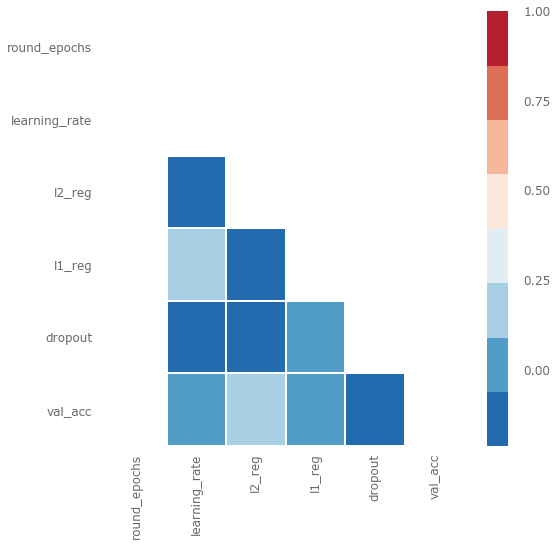

In [17]:
a = ta.Analyze(t)
a.plot_corr('val_acc', ['loss', 'acc', 'precision', 'recall', 'f1score',
                            'val_loss', 'val_acc', 'val_precision', 'val_recall'])

In [19]:
#  
sgd=optimizers.SGD(lr=0.01)
bestmodel.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

print("""test loss: %.2f
test accuracy: %.2f
""" % tuple(bestmodel.evaluate(X_test, y_test)))

42/42 [==============================] - 2s 38ms/step
test loss: 71.53
test accuracy: 0.79



In [20]:
predicted_classes = bestmodel.predict(X_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(6)]
y_test_classes = np.argmax(y_test, axis=-1)
print(classification_report(y_test_classes, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.29      1.00      0.44         2
     Class 1       0.00      0.00      0.00         4
     Class 2       0.50      0.67      0.57         9
     Class 3       1.00      1.00      1.00        10
     Class 4       1.00      0.81      0.90        16
     Class 5       0.00      0.00      0.00         1

    accuracy                           0.74        42
   macro avg       0.46      0.58      0.49        42
weighted avg       0.74      0.74      0.72        42



In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_classes, predicted_classes)

array([[ 2,  0,  0,  0,  0,  0],
       [ 1,  0,  3,  0,  0,  0],
       [ 3,  0,  6,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0],
       [ 0,  0,  3,  0, 13,  0],
       [ 1,  0,  0,  0,  0,  0]])